In [1]:
from __future__ import division
from pyomo.environ import *

from pyomo.opt import SolverFactory
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

In [2]:
Model = ConcreteModel()

p = ['avion_1', 'avion_2', 'avion_3']
j = ['alimentos', 'medicinas', 'equipos', 'agua', 'mantas']

# datos aviones
capacidadPAviones = {'avion_1':30, 'avion_2':40, 'avion_3':50}
capacidadVAviones = {'avion_1':25, 'avion_2':30, 'avion_3':35}

# datos recursos
valorRecursos = {'alimentos':50, 'medicinas':100, 'equipos':120, 'agua':60, 'mantas':40}
pesoRecursos = {'alimentos':15, 'medicinas':5, 'equipos':20, 'agua':18, 'mantas':10}
volumenRecursos = {'alimentos':8, 'medicinas':2, 'equipos':10, 'agua':12, 'mantas':6}


## Variable de decision

In [3]:
Model.x =  Var(p,j,domain=Binary)

## Modelo matematico

### Modelo matemático del Problema de la Misión Humanitaria en Zambia

- **Conjuntos**:
  - El conjunto de aviones P
  - El conjunto de recursos R

- **Índices**:
  - Se usará el índice \( i \) para indexar cada elemento del conjunto \( P \) (aviones).
  - Se usará el índice \( j \) para indexar cada elemento del conjunto \( R \) (recursos).

- **Parámetros**:
  - \( v_j \): valor del recurso \( j \), donde \( j \in R \).
  - \( p_j \): peso del recurso \( j \), donde \( j \in R \).
  - \( q_j \): volumen del recurso \( j \), donde \( j \in R \).
  - \( c_i^p \): capacidad de peso del avión \( i \), donde \( i \in P \).
  - \( c_i^v \): capacidad de volumen del avión \( i \), donde \( i \in P \).

- **Variable de Decisión**:
  - Se propone una \( x_{ij} \) binaria, donde 1 indica que el recurso \( j \) es transportado en el avión \( i \), y 0 en caso contrario.

- **Función objetivo**:

$$
\text{Maximizar: } \sum_{i \in P} \sum_{j \in R} v_j \cdot x_{ij}
$$

- **Restricciones**:

  - **Capacidad de Peso**:

$$
\sum_{j \in R} p_j \cdot x_{ij} \leq c_i^p, \quad \forall i \in P
$$

  - **Capacidad de Volumen**:

$$
\sum_{j \in R} q_j \cdot x_{ij} \leq c_i^v, \quad \forall i \in P
$$

  - **Compatibilidad de Recursos (equipos y agua)**:

$$
x_{i, \text{equipos}} + x_{i, \text{agua}} \leq 1, \quad \forall i \in P
$$

  - **Asignación Exclusiva de Recursos**:

$$
\sum_{i \in P} x_{ij} \leq 1, \quad \forall j \in R
$$

  - **Seguridad de Medicinas**:

$$
x_{\text{avion\_1}, \text{medicinas}} = 0
$$



In [4]:
Model.obj = Objective(expr= sum(Model.x[av, rc]*valorRecursos[rc] for av in p for rc in j), sense=maximize)

## Restricciones

In [5]:
Model.pesoMaximo = ConstraintList()
Model.volumenMaximo = ConstraintList()
Model.recursoUsado = ConstraintList()
Model.compatibilidad = ConstraintList()

for av in p:
    Model.pesoMaximo.add(expr= sum(Model.x[av,rc]*pesoRecursos[rc] for rc in j) <= capacidadPAviones[av])
    Model.volumenMaximo.add(expr= sum(Model.x[av,rc]*volumenRecursos[rc] for rc in j) <= capacidadVAviones[av])
    Model.compatibilidad.add(expr= (Model.x[av, 'equipos'] + Model.x[av, 'agua']) <= 1)

for rc in j:
    Model.recursoUsado.add(expr= sum(Model.x[av, rc] for av in p) <= 1)

Model.seguridadMedi = Constraint(expr= (Model.x['avion_1','medicinas'] == 0))


## Solver

In [6]:
SolverFactory('glpk').solve(Model)

{'Problem': [{'Name': 'unknown', 'Lower bound': 370.0, 'Upper bound': 370.0, 'Number of objectives': 1, 'Number of constraints': 15, 'Number of variables': 15, 'Number of nonzeros': 52, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': '3', 'Number of created subproblems': '3'}}, 'Error rc': 0, 'Time': 0.004751920700073242}], 'Solution': [OrderedDict({'number of solutions': 0, 'number of solutions displayed': 0})]}

In [7]:
Model.display()

Model unknown

  Variables:
    x : Size=15, Index={avion_1, avion_2, avion_3}*{alimentos, medicinas, equipos, agua, mantas}
        Key                      : Lower : Value : Upper : Fixed : Stale : Domain
             ('avion_1', 'agua') :     0 :   0.0 :     1 : False : False : Binary
        ('avion_1', 'alimentos') :     0 :   1.0 :     1 : False : False : Binary
          ('avion_1', 'equipos') :     0 :   0.0 :     1 : False : False : Binary
           ('avion_1', 'mantas') :     0 :   0.0 :     1 : False : False : Binary
        ('avion_1', 'medicinas') :     0 :   0.0 :     1 : False : False : Binary
             ('avion_2', 'agua') :     0 :   0.0 :     1 : False : False : Binary
        ('avion_2', 'alimentos') :     0 :   0.0 :     1 : False : False : Binary
          ('avion_2', 'equipos') :     0 :   1.0 :     1 : False : False : Binary
           ('avion_2', 'mantas') :     0 :   1.0 :     1 : False : False : Binary
        ('avion_2', 'medicinas') :     0 :   1.0 :     

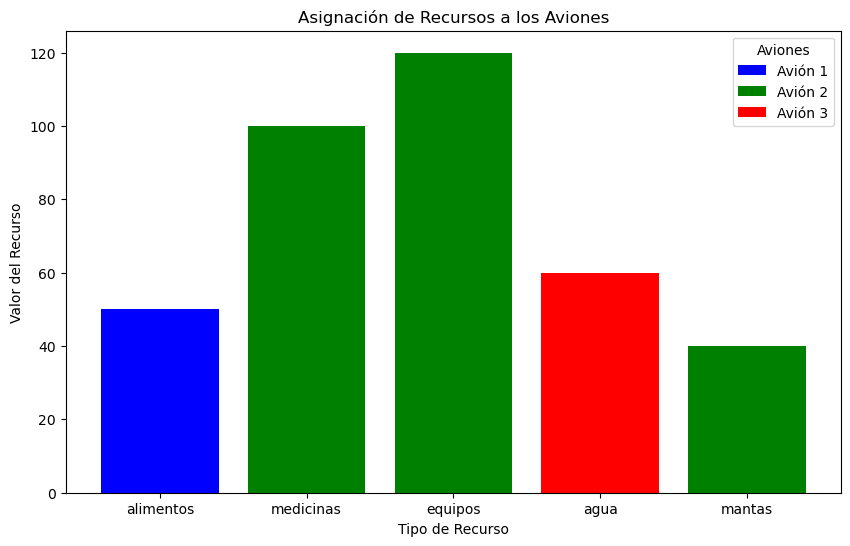

In [8]:
colores = {'avion_1': 'blue', 'avion_2': 'green', 'avion_3': 'red'}
labels = {'avion_1': 'Avión 1', 'avion_2': 'Avión 2', 'avion_3': 'Avión 3'}

recursos = []
valores = []
colores_barras = []

for rc in j:
    for av in p:
        if Model.x[av, rc].value == 1:
            recursos.append(rc)
            valores.append(valorRecursos[rc])
            colores_barras.append(colores[av])

plt.figure(figsize=(10, 6))
plt.bar(recursos, valores, color=colores_barras)

for avion, color in colores.items():
    plt.bar(0, 0, color=color, label=labels[avion])

plt.xlabel('Tipo de Recurso')
plt.ylabel('Valor del Recurso')
plt.title('Asignación de Recursos a los Aviones')
plt.legend(title='Aviones')
plt.show()


## Analisis de los resultados

Alimentos Básicos (Avión 1): Este recurso, con un valor de 50, fue asignado al Avión 1, que es capaz de manejar su peso y volumen sin dificultades. Dado que los alimentos son esenciales pero tienen un valor menor en comparación con otros recursos, esta asignación asegura que los recursos más valiosos puedan utilizar los aviones con mayores capacidades.

Medicinas (Avión 2): Las medicinas, con un valor de 100, se asignaron al Avión 2. Esta decisión está alineada con la restricción que impide que las medicinas sean transportadas en el Avión 1 debido a la falta de condiciones adecuadas. El Avión 2, que sí cumple con estas condiciones, se convierte en el medio de transporte ideal, garantizando que los medicamentos lleguen a su destino en condiciones óptimas.

Equipos Médicos (Avión 2): Con un valor de 120, los equipos médicos son el recurso más valioso y también se asignaron al Avión 2. La decisión de combinar los equipos médicos con las medicinas en el mismo avión maximiza el uso de la capacidad disponible en términos de valor, asegurando que los recursos más críticos lleguen juntos. Además, se respeta la restricción de compatibilidad con el agua potable.

Agua Potable (Avión 3): El agua potable, valorada en 60, fue asignada al Avión 3. Esto evita cualquier riesgo de contaminación cruzada con los equipos médicos, cumpliendo con las restricciones impuestas en el modelo. Además, el Avión 3 tiene suficiente capacidad tanto en peso como en volumen para transportar este recurso de manera eficiente.

Mantas (Avión 2): Las mantas, con un valor de 40, también fueron asignadas al Avión 2. Aunque este recurso tiene un valor menor, su inclusión en este avión demuestra que aún había capacidad disponible después de asignar los recursos más críticos.

En conjunto, la asignación realizada optimiza el valor total transportado mientras respeta las restricciones del modelo, garantizando que los recursos más valiosos y delicados sean manejados adecuadamente. La gráfica visualiza claramente cómo se han distribuido los recursos entre los aviones, destacando la eficiencia del modelo en términos de maximización del valor y cumplimiento de restricciones logísticas.

## Implicaciones de decisiones tomadas

El modelo matemático fue planteado como un problema de optimización lineal, con un objetivo claro de maximizar el valor de los recursos transportados. Las decisiones tomadas en cuanto a las restricciones —como las de peso, volumen, y compatibilidad— aseguran que la solución sea factible en un escenario real. En el código, estas restricciones fueron implementadas cuidadosamente para reflejar las limitaciones logísticas de la misión.

Las decisiones de modelar las variables como binarias permiten un control preciso sobre qué recursos se asignan a cada avión. Esto también facilita la interpretación de los resultados, aun asi para la mejor visualizacion optamos por graficar para asi tener un contexto mas amigable hacia la comprension de estos.

##  Impacto de las restricciones de almacenamiento de recursos

Las restricciones de almacenamiento juegan un papel fundamental en la efectividad del modelo de optimización, garantizando no solo la maximización del valor de los recursos transportados, sino también su integridad y seguridad durante el transporte.

Restricciones:

-**Seguridad de medicamentos**: Esta restricción asegura que los medicamentos no sean transportados en el Avión 1, ya que este avión carece de las condiciones necesarias para mantener la temperatura adecuada. La imposición de esta restricción garantiza que los medicamentos mantengan su efectividad al llegar a su destino, evitando cualquier degradación que pudiera ocurrir debido a condiciones de almacenamiento inadecuadas. Por lo tanto  al momento de resolver el modelo se restrinje el ingresar a la lista optimizada este resultado que no cumple con esta restriccion.

-**Compatibilidad entre Equipos Médicos y Agua Potable**: Esta restricción prohíbe que los equipos médicos y el agua potable se transporten en el mismo avión para evitar riesgos de contaminación cruzada. Los equipos médicos son sensibles y podrían ser dañados si entran en contacto con el agua, lo que podría comprometer su funcionalidad en el campo. Esta medida asegura que ambos recursos lleguen en perfectas condiciones, manteniendo la eficacia de la misión humanitaria. Esto impacta muy directamente a la lista optimizada ya que por la reduccion de opciones gracias a la restriccion puede que no se logre cumplir la meta de cantidad necesaria y que sea optima para realizar la mision.

-**Capacidades Máximas de Peso y Volumen**: Estas restricciones aseguran que ningún avión sea sobrecargado más allá de sus capacidades físicas. Respetar las limitaciones de peso y volumen es podriamos decir que es crucial para evitar situaciones donde el avión no pueda despegar o mantener un vuelo seguro, lo que podría poner en peligro la misión y las vidas de los tripulantes.

-**Uso Único de Recursos**:  Esta restricción asegura que cada recurso se asigna a un solo avión, evitando duplicaciones y asegurando una distribución clara y precisa de los recursos.

**Impacto en la solucion de estas restricciones**: Estas restricciones tienen un impacto significativo en la solución al obligar al modelo a encontrar un balance entre maximizar el valor total transportado y asegurar la integridad de los recursos. Sin estas restricciones, el modelo podría generar soluciones que maximizan el valor transportado a costa de la seguridad o la calidad de los recursos. Esto sería especialmente perjudicial en el contexto de una misión humanitaria, donde cada recurso debe llegar en condiciones óptimas para ser efectivo. Así, las restricciones de almacenamiento aseguran que la solución sea tanto óptima como viable en un escenario real, donde la calidad y la seguridad son tan importantes como el valor.